# Feed Forward Neural Network 

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import scanpy as sc
import os
from numpy.random import seed
# from tensorflow import set_random_seed
import warnings
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from scipy.stats import rankdata
# from fancyimpute import IterativeImputer

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
warnings.filterwarnings("ignore")

In [5]:
adata_train=sc.read('/content/drive/MyDrive/Shared resources/Bh.h5ad')
adata_test=sc.read('/content/drive/MyDrive/Shared resources/smartseq2.h5ad')

In [6]:
len(adata_train.obs["celltype"])

8569

In [7]:
#/Utils/preprocess.py
def preprocess(adata_test, min_genes = 200, min_cells = 20, target_sum = 1e6, n_top_genes = 3000, max_value = 10, get_hvgs=False, scale_and_hvgs = False):
        """
        INPUT:
        file_path: path to .h5ad containing scRNA-seq
        """
        ## convert to h5ad
        # adata_test = sc.AnnData(genes, labels)

        ## make var names unique
        adata_test.obs_names_make_unique()
        adata_test.var_names_make_unique()

    ## filter cells with count less than 200
        sc.pp.filter_cells(adata_test, min_genes=min_genes)

        ## filter genes with count less than 20
        sc.pp.filter_genes(adata_test, min_cells=min_cells)

        ## normalise data
        sc.pp.normalize_total(adata_test, target_sum=target_sum)

        ## LogNormalise
        if not(scale_and_hvgs):
                return {'data':adata_test}

        if get_hvgs:
                ## Get HVGS
                sc.pp.log1p(adata_test)
                sc.pp.highly_variable_genes(adata_test, n_top_genes = n_top_genes)
                adata_test = adata_test[:, adata_test.var.highly_variable]

                ## scale data
                sc.pp.scale(adata_test, max_value=max_value)
                return {'data' : adata_test, 'hvg': adata_test.var.highly_variable}

        ## scale data
        sc.pp.scale(adata_test, max_value=max_value)
        return {'data':adata_test}

In [8]:
print("Starting preprocessing...")
train_dic = preprocess(adata_train, min_cells=20,min_genes=50, get_hvgs = True, scale_and_hvgs = True)
test_dic = preprocess(adata_test, min_cells=0, min_genes=0)

Starting preprocessing...


In [9]:
train_adata_pp =  train_dic['data']
test_adata_pp =  test_dic['data']

In [10]:
train_df = train_adata_pp.to_df()
test_df = test_adata_pp.to_df()

In [11]:
y_train = train_adata_pp.obs.celltype.to_list()
y_test = test_adata_pp.obs.celltype.to_list()

For new dataset, next three cells 

In [12]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/Shared resources/Train_new.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Shared resources/Test_new.csv')

In [13]:
y_train = train_df['celltype'].to_list()
y_test = test_df['celltype'].to_list()

In [14]:
## taking common genes
print("Taking common genes...")
final_columns = list(set(train_df.columns).intersection(set(test_df.columns)))
print('Common columns', len(final_columns))
final_columns = [i for i in final_columns if i != 'celltype'] 
train_df = train_df[final_columns]
test_df = test_df[final_columns]

Taking common genes...
Common columns 2968


In [15]:
# count of celltypes in test data
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{'acinar': 188,
 'activated_stellate': 55,
 'alpha': 1008,
 'beta': 308,
 'delta': 127,
 'ductal': 444,
 'endothelial': 21,
 'epsilon': 8,
 'gamma': 213,
 'macrophage': 7,
 'mast': 7,
 'quiescent_stellate': 6,
 'schwann': 2}

In [16]:
# count of celltypes in train data
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'acinar': 2874,
 'activated_stellate': 852,
 'alpha': 6978,
 'beta': 7575,
 'delta': 1803,
 'ductal': 3231,
 'endothelial': 756,
 'epsilon': 54,
 'gamma': 765,
 'macrophage': 165,
 'mast': 75,
 'quiescent_stellate': 519,
 'schwann': 39,
 't_cell': 21}

In [17]:
print(len(y_train))
print(len(y_test))

25707
2394


Rank Transform

In [18]:
def rank_transform(feats):
        '''converts features to ranks'''
        rows = []
        cols = list(feats.columns)
#       ind = list(feats.index)
        for ind in feats.index.to_list():
                c_r = []
                for col in cols:
                        c_r.append(feats.loc[ind,col])
                rows.append([int(x) for x in rankdata(c_r)])
        feats = pd.DataFrame(rows)
        feats.columns = cols
#       feats.index = ind
        return feats

In [19]:
train_df

,MS4A6A,TDRD6,MGLL,ZBTB46,SIGLEC14,CLCN4,SNX9,C2CD4A,KIF12,ANGPT1,...,EGR3,CLRN3,BMP4,COQ10A,ATF3,PPP1R18,TFF1,ACACB,HMMR,FOXC2
0,513,694,2112,1389,138,2002,2503,2557,2224,626,...,1591,493,932,2175,2687,2833,1153,1855,483,784
1,515,691,2082,1388,140,1979,2427,2476,2191,626,...,1589,495,929,2142,2409,2208,1150,2928,485,781
2,514,694,2150,1394,139,2023,2782,2666,2274,627,...,1597,494,933,2893,2582,2291,1156,1876,484,784
3,515,694,2107,1387,140,1996,2502,2557,2227,628,...,1587,495,929,2176,2483,2245,1150,2904,485,783
4,514,695,2132,1397,139,2018,2559,2616,2255,627,...,1599,494,934,2204,2793,2272,1156,1875,484,785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25702,512,691,2081,1378,139,1968,2789,2667,2216,624,...,1563,492,927,2164,2566,2236,1144,1822,482,781
25703,514,695,2176,1398,139,2045,2918,2799,2322,627,...,1605,494,933,2263,2693,2343,1156,1892,484,785
25704,514,695,2184,1399,139,2053,2727,2902,2327,627,...,1606,494,934,2273,2919,2346,1157,1898,484,785
25705,513,694,2179,1399,138,2049,2714,2797,2321,626,...,1607,493,933,2265,2687,2341,1157,1894,483,784


In [20]:
X_train = train_df.to_numpy()
X_test = test_df.to_numpy()

In [21]:
labels = set(y_train)
mapping = {}
cnt = 0
for lab in set(y_train):
  if lab in mapping:
    continue
  mapping[lab] = cnt
  cnt += 1


In [22]:
y_test_lab = []
for i in y_test:
  if i in mapping:
    y_test_lab.append(mapping[i])
  else:
    y_test_lab.append(0)
y_test = np.array(y_test_lab)

In [23]:
y_train_lab = []
for i in y_train:
  if i in mapping:
    y_train_lab.append(mapping[i])
  else:
    y_train_lab.append(0)
y_train = np.array(y_train_lab)

In [24]:
print(len(mapping))

14


In [25]:
y_test_cat = np.zeros((y_test.shape[0], 14))
y_train_cat = np.zeros((y_train.shape[0], 14))

In [26]:
y_test_cat.shape

(2394, 14)

In [27]:
def convert_to_cat(y_new, y):
  for i in range(y.shape[0]):
    y_new[i, y[i]] = 1
  return y_new
y_test_cat = convert_to_cat(y_test_cat, y_test)
y_train_cat = convert_to_cat(y_train_cat, y_train)

In [28]:
!pip3 install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
np.random.seed(2)

##loading 90% Training data
directory = '/content/drive/MyDrive/Shared resources/'
project_name = 'Boosted_matrix_dataset_hyperparameter_tuning'


##Definining hyper parameters 
layers_range = (3, 6)
units_range = (128, 1024, 128)
lr_values = [1e-4,3e-5,1e-5]

##Define model
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(units = 1024,input_dim = 2967, activation = 'relu'))

  for i in range(hp.Int('layers', layers_range[0], layers_range[1])):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),  
                                min_value=units_range[0], max_value=units_range[1], 
                                step=units_range[2]), activation='relu'))

    
    model.add(keras.layers.Dense(14, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=lr_values)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()]) 
  return model

##Perform hyperparameter tuning
for i in range(5):
    offset = (X_train.shape[0]*9)//10
    tuner = kt.Hyperband(model_builder, # the hypermodel
                    objective='val_loss', # objective to optimize
                    max_epochs=256,
                    factor=2, 
                    directory=directory, # directory to save logs 
                    project_name=project_name+str(i+1))
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    tuner.search(X_train, y_train_cat, epochs=400, batch_size = 4096*4, validation_data = (X_test, y_test_cat), callbacks=[stop_early])
    best_hp=tuner.get_best_hyperparameters()[0]
    best_model = tuner.get_best_models()[0]
    
    # Build the model with the optimal hyperparameters
    h_model = tuner.hypermodel.build(best_hp)
    h_model.fit(X_train, y_train_cat, epochs=200, verbose = 1, batch_size = 4096*4, validation_data = (X_test, y_test_cat))
    h_model.save('precily_cv_'+str(i+1)+'.hdf5')
    h_model = None
    


Trial 1 Complete [00h 00m 30s]
val_loss: 2.6366124153137207

Best val_loss So Far: 2.6366124153137207
Total elapsed time: 00h 00m 30s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
3                 |5                 |layers
640               |1024              |units_0
1e-05             |3e-05             |learning_rate
640               |128               |units_1
896               |1024              |units_2
768               |128               |units_3
768               |128               |units_4
1                 |1                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
8                 |8                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: ignored

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1024,input_dim = 2967, activation = 'relu'))

# for i in range(4):
#   model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(14, activation='softmax'))
hp_learning_rate = 3e-5
model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()]) 

In [ ]:
y_test_cat.shape

(2394, 14)

In [ ]:
model.fit(X_train, y_train_cat, epochs=1000, verbose = 1, batch_size = 4096*4, validation_data = (X_test, y_test_cat))

Epoch 1/1000
2/2 [==============================] - 31s 10s/step - loss: 835.7006 - auc_4: 0.5092 - categorical_accuracy: 0.0887 - val_loss: 662.6644 - val_auc_4: 0.5074 - val_categorical_accuracy: 0.0852
Epoch 2/1000
2/2 [==============================] - 12s 5s/step - loss: 458.0695 - auc_4: 0.6080 - categorical_accuracy: 0.2694 - val_loss: 526.2857 - val_auc_4: 0.5731 - val_categorical_accuracy: 0.2063
Epoch 3/1000
2/2 [==============================] - 10s 5s/step - loss: 370.0985 - auc_4: 0.5977 - categorical_accuracy: 0.2505 - val_loss: 400.5899 - val_auc_4: 0.5263 - val_categorical_accuracy: 0.1195
Epoch 4/1000
2/2 [==============================] - 11s 3s/step - loss: 229.8851 - auc_4: 0.5917 - categorical_accuracy: 0.2357 - val_loss: 261.5270 - val_auc_4: 0.5639 - val_categorical_accuracy: 0.1834
Epoch 5/1000
2/2 [==============================] - 9s 3s/step - loss: 156.1114 - auc_4: 0.5869 - categorical_accuracy: 0.2252 - val_loss: 234.6063 - val_auc_4: 0.6191 - val_categoric

KeyboardInterrupt: ignored

In [ ]:
!rm -rf trail 


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Create model object
# clf = MLPClassifier(hidden_layer_sizes=( 1000 , 600 ,  400  , 250   , 150   , 100 , 70  , 20 ),
#                     random_state=5,
#                     verbose=True,
#                     learning_rate_init=0.01)

mlpg = MLPClassifier(max_iter = 10)
parameters = {'activation':('identity','logistic','tanh','relu'), 'learning_rate_init':[0.1,0.01,0.001], 'hidden_layer_sizes' : [( 1000,600,400,250,150,100,70,20)],
              'batch_size' :[128,256]}
gs = GridSearchCV(mlpg,parameters,cv = 3, scoring = 'neg_log_loss', verbose = 1)
gs.fit(X_train,y_train)

# Fit data onto the model
# clf.fit(X_train,y_train)

# loss=1.89 approx

Fitting 3 folds for each of 84 candidates, totalling 252 fits


In [ ]:
from sklearn.neural_network import MLPClassifier

# Create model object
clf = MLPClassifier(hidden_layer_sizes=( 1000 , 600 ,  400  , 250   , 150   , 100 , 70  , 20 ),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01,
                    max_iter = 10)

# Fit data onto the model
clf.fit(X_train,y_train)

# loss=1.89 approx

Iteration 1, loss = 8.49514851
Iteration 2, loss = 6.38097813
Iteration 3, loss = 2.17286648
Iteration 4, loss = 2.07544355
Iteration 5, loss = 2.01687856
Iteration 6, loss = 1.97994890
Iteration 7, loss = 1.95918874
Iteration 8, loss = 1.94407498
Iteration 9, loss = 1.93466418
Iteration 10, loss = 1.92810169


MLPClassifier(hidden_layer_sizes=(1000, 600, 400, 250, 150, 100, 70, 20),
              learning_rate_init=0.01, max_iter=10, random_state=5,
              verbose=True)

In [ ]:
y_pred = clf.predict(test_rank)

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{'alpha': 2394}

In [ ]:
# Import accuracy score 
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.42105263157894735

In [ ]:
## class wise accuracy 

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
acc = cm.diagonal()
acc = acc*100

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
unique

array(['acinar', 'activated_stellate', 'alpha', 'beta', 'delta', 'ductal',
       'endothelial', 'epsilon', 'gamma', 'macrophage', 'mast',
       'quiescent_stellate', 'schwann'], dtype='<U18')

<BarContainer object of 13 artists>

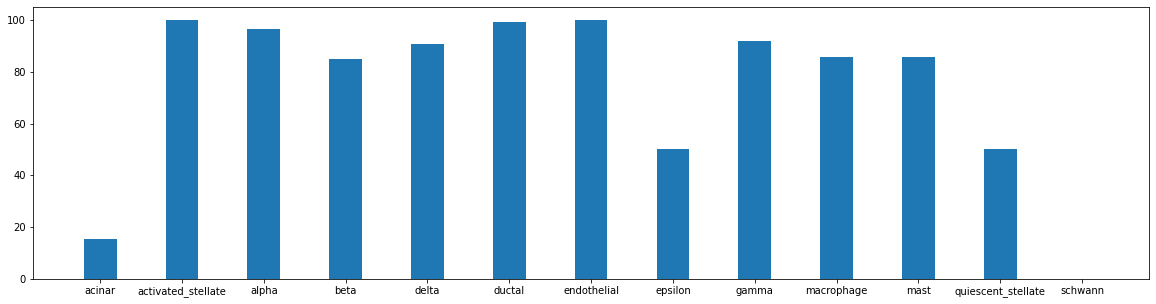

In [ ]:
fig = plt.figure(figsize = (20, 5))
plt.bar(unique,acc,width = 0.4)

## Result


Accuracy Score came out to be approximately 88.22 %